In [6]:

import datetime as dt
import xarray as xr
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import plotly.express as px
# make plotly visbile in vscode
import plotly.io as pio
pio.renderers.default = "notebook_connected"

### Explore 5 years of ERA5 atmospheric river data

In [7]:
# open the a water year data and start exploring
year = 2019
ds = xr.open_dataset(f'../data/02_processed/AR_Events/lpt_systems_AR_{year-1}050100_{year}043018.nc')

# filter the centroid_lon_end to be between 225 and 245 and the centroid_lat_end to be between 40 and 55
ds_filter_01 = ds.where((ds.centroid_lon_end > 235) & 
              (ds.centroid_lat_end > 45) & 
              (ds.centroid_lat_end < 52), drop=True)

In [8]:
print(f'Total number of events in {year}: ', ds_filter_01.nlpt.size)
event_list = []
cols_to_exclude = ['lptid', 'nlpt', 'num_objects', 'max_filtered_running_field', 'max_inst_field', 
                   'min_filtered_running_field','min_filtered_running_field','amean_inst_field',
                   'amean_running_field', 'amean_filtered_running_field', 'min_inst_field',
                   'max_lon_stitched', 'max_lat_stitched', 'min_lon_stitched',
                   'min_lat_stitched', 'lpt_begin_index', 'lpt_end_index',
                   'lptid_stitched','nobj_stitched',]
for i in range(ds_filter_01.nlpt.size):
    lpt_begin_index = ds_filter_01.lpt_begin_index.values.astype(int)
    lpt_end_index = ds_filter_01.lpt_end_index.values.astype(int)
    # filter to a specific event
    tmp_ds = ds_filter_01.isel(nlpt=i, nstitch=slice(lpt_begin_index[i],lpt_end_index[i])).drop_dims('nobj')
    
    event_list.append(tmp_ds.where(tmp_ds.max_running_field==tmp_ds.max_running_field.max(), drop=True).to_pandas().drop(cols_to_exclude, axis=1))

Total number of events in 2019:  20


In [9]:
# Concatenate all the events into one dataframe
event_df = pd.concat(event_list, axis=0).reset_index(drop=True)

<Axes: >

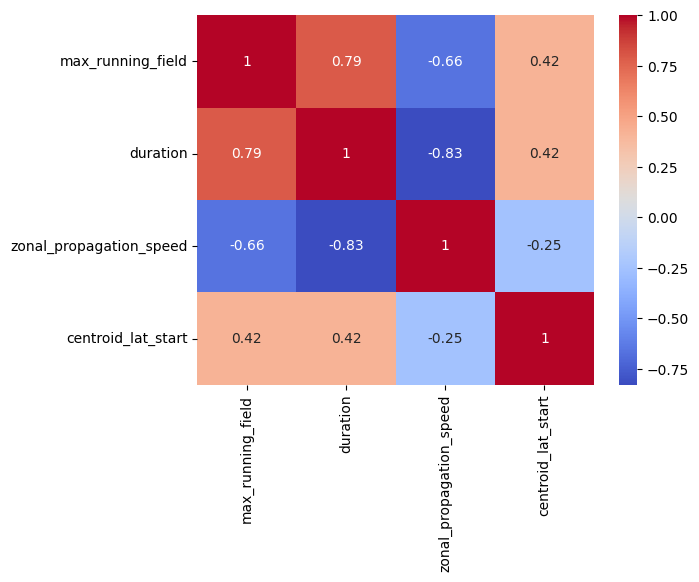

In [10]:
# Use seaborn to create a heatmap of the data to look for correlations between variables
# first, choose a few variables to compare
cols_to_compare = ['max_running_field', 'duration', 'zonal_propagation_speed', 'centroid_lat_start']
sns.heatmap(event_df[cols_to_compare].corr(), annot=True, cmap='coolwarm')


Okay, we have a way of looking at this data. Now lets make a combined dataset over these years to classify the ARs

In [11]:
years = [2015, 2016, 2017, 2018, 2019]
event_list = []
for year in years:
    ds = xr.open_dataset(f'../data/02_processed/AR_Events/lpt_systems_AR_{year-1}050100_{year}043018.nc')

    # filter the centroid_lon_end to be between 225 and 245 and the centroid_lat_end to be between 40 and 55
    ds_filter_01 = ds.where((ds.centroid_lon_end > 235) & 
                (ds.centroid_lat_end > 45) & 
                (ds.centroid_lat_end < 52), drop=True)

    for i in range(ds_filter_01.nlpt.size):
        lpt_begin_index = ds_filter_01.lpt_begin_index.values.astype(int)
        lpt_end_index = ds_filter_01.lpt_end_index.values.astype(int)
        # filter to a specific event
        tmp_ds = ds_filter_01.isel(nlpt=i, nstitch=slice(lpt_begin_index[i],lpt_end_index[i])).drop_dims('nobj')
        
        event_list.append(tmp_ds.where(tmp_ds.max_running_field==tmp_ds.max_running_field.max(), drop=True).to_pandas().drop(cols_to_exclude, axis=1))

<Axes: >

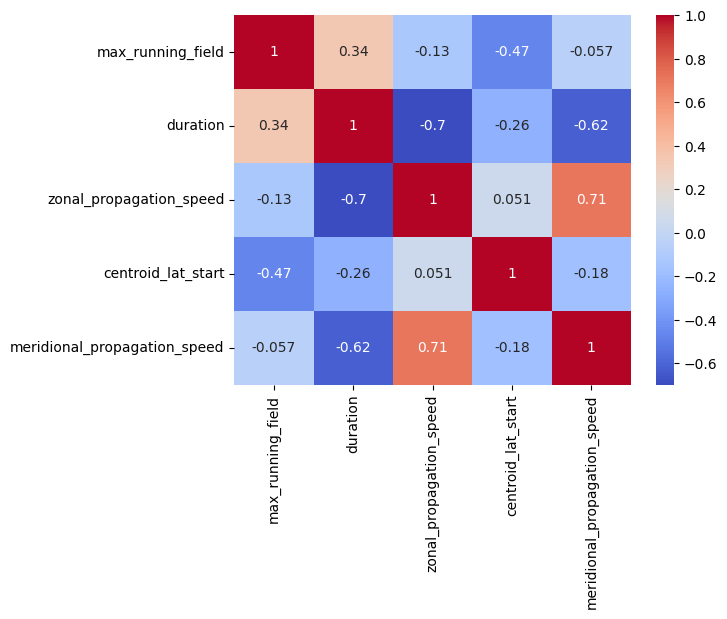

In [12]:
# Concatenate all the events into one dataframe
event_df = pd.concat(event_list, axis=0)
# filter timestamp_stiched to months 11-4
event_df = event_df[(event_df.timestamp_stitched.dt.month >= 11) | (event_df.timestamp_stitched.dt.month <= 4)]
event_df['event_start'] = event_df['timestamp_stitched']
event_df['event_end'] = event_df['timestamp_stitched'] + event_df['duration']
# convert duration to hours as save as an integer
event_df['duration'] =event_df['duration'].dt.days * 24
# reset index
event_df = event_df.reset_index(drop=True)
# Use seaborn to create a heatmap of the data to look for correlations between variables
# first, choose a few variables to compare
cols_to_compare = ['max_running_field', 'duration', 'zonal_propagation_speed', 'centroid_lat_start', 'meridional_propagation_speed']
sns.heatmap(event_df[cols_to_compare].corr(), annot=True, cmap='coolwarm')


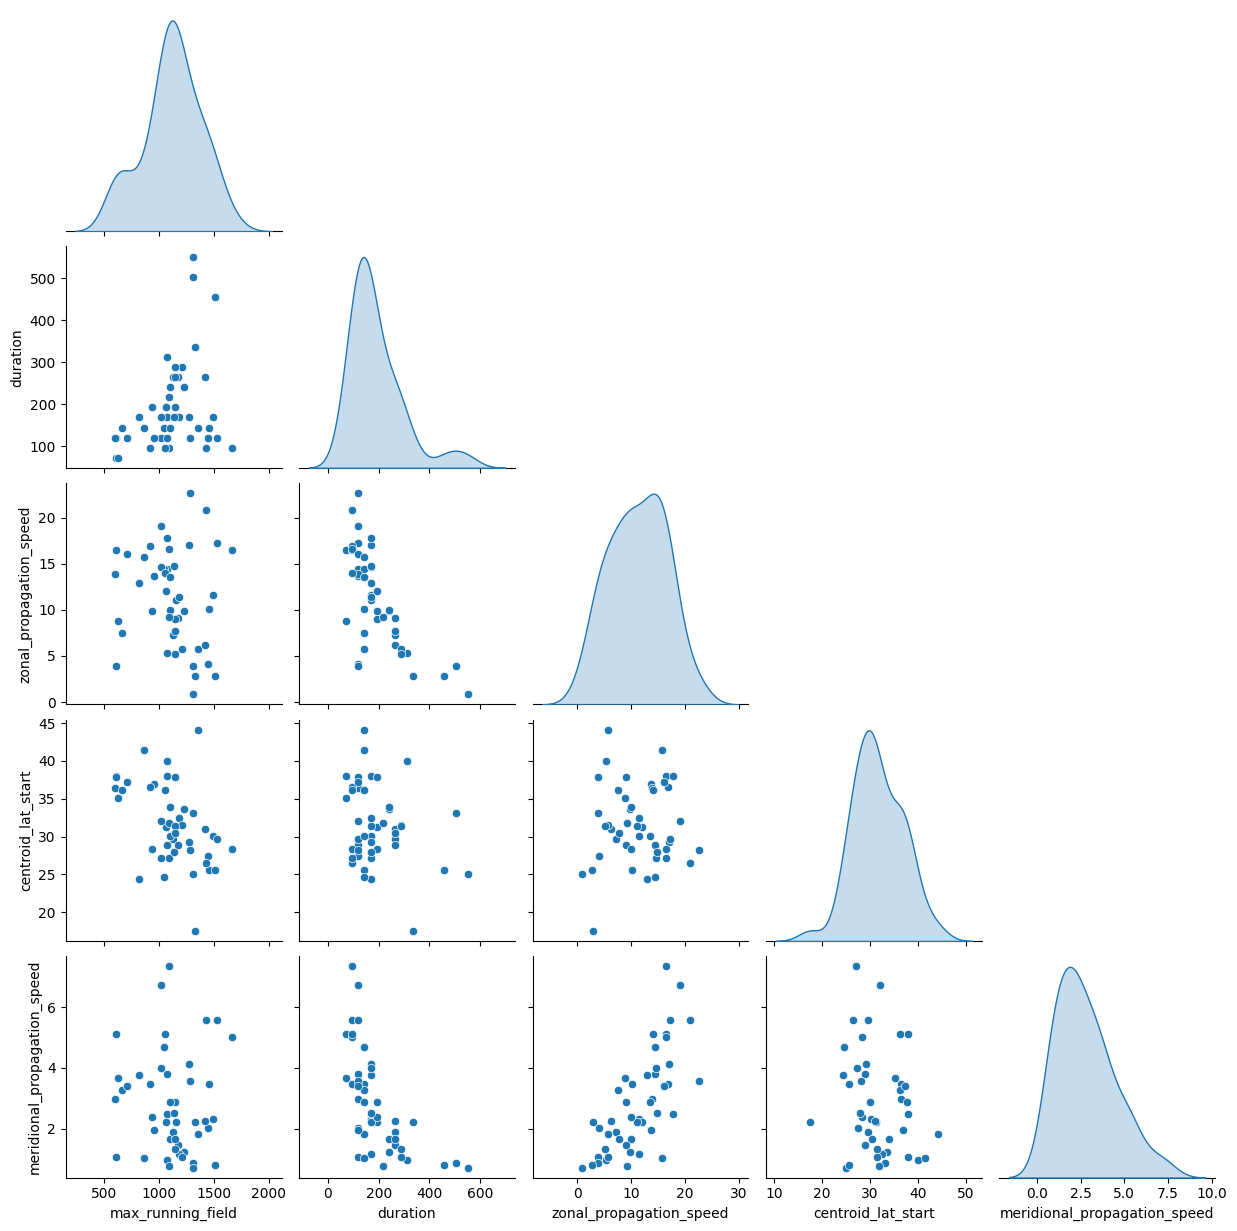

In [13]:
# create a correllogram to look for correlations between variables
sns.pairplot(event_df[cols_to_compare], diag_kind='kde', corner=True)

### Working with ERA-Interim-AR-Classification data
This data was taken from a paper repository for [this publication]([https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2022JD037180).

In [14]:
# first see if ARscale_spatial_filtered is a file
if os.path.isfile('../data/02_processed/ERA-Interim-AR-Classification/ARscale_spatial_filtered.nc'):
    print(f'File exists, opening ARscale_spatial_filtered.nc...')
    ds_filter_01 = xr.open_dataset(f'../data/02_processed/ERA-Interim-AR-Classification/ARscale_spatial_filtered.nc')
else:
    print('Need to create file...')
    ds = xr.open_dataset(f'../data/02_processed/ERA-Interim-AR-Classification/ARscale.nc')
    ds_filter_01 = ds.where((ds.lon > 235) & 
                        (ds.lon < 240) &
                        (ds.lat > 45) & 
                        (ds.lat < 52), drop=True)
    # save as a new file
    ds_filter_01.to_netcdf(f'../data/02_processed/ERA-Interim-AR-Classification/ARscale_spatial_filtered.nc')



File exists, opening ARscale_spatial_filtered.nc...


In [15]:
# drop nans for time, but not all cells need to have data
ds_filter_02 = ds_filter_01.scale.squeeze().dropna(dim='time', how='all')
# filter to the years since water year 2015
ds_filter_03 = ds_filter_02.where((ds_filter_02.time.dt.year > 2013) &
                                  (ds_filter_02.time.dt.year < 2020) &
                                  (ds_filter_02.time.dt.month.isin([11,12,1,2,3,4])) &
                                  (ds_filter_02.time.dt.date > dt.date(2014,10,31)) &
                                  (ds_filter_02>0), drop=True)
# take the zonal and meridional median values
# this essentially will take the median value within the grid cells we defined as 
ds_filter_04 = ds_filter_03.median(dim='lon').median(dim='lat')
# conert to integer values and drop values less than 1
ds_filter_05 = ds_filter_04.astype(int)

In [16]:
# convert to a dataframe
df = ds_filter_05.to_dataframe()
# add a column for the date
df['date'] = df.index.date
# add a column as time difference from the previous index
df['time_diff'] = df.index.to_series().diff().dt.days

# iterate through the time_diff column, if the value is zero, store the same event id value, if the value is non-zero, add 1 to the event_id and store the value
event_id = 0
event_list = []
for val in df.time_diff:
    if val == 0:
        event_list.append(event_id)
    else:
        event_id += 1
        event_list.append(event_id)
# add event_id column to the dataframe
df['event_id'] = event_list


Text(0.5, 1.0, 'Distribution of AR Scale for Events in the PNW between 2015 and 2019')

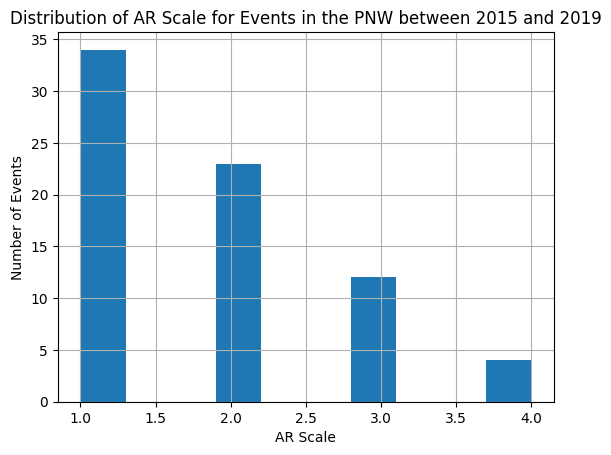

In [17]:
# groupby event ids
grouped_df = df.groupby('event_id').agg({'date': ['first', 'last'], 'time_diff': 'count', 'scale': 'max'})
# multiply time_diff by 6 to get the duration in hours
grouped_df['duration'] = grouped_df['time_diff'] * 6
grouped_df['scale'].hist()
# add x and y labels
plt.xlabel('AR Scale')
plt.ylabel('Number of Events')
# add a title
plt.title('Distribution of AR Scale for Events in the PNW between 2015 and 2019')

### Working with ERA5 atmospheric data

In [30]:
year = 2017
era5_ds = xr.open_dataset(f'../data/01_raw/era5_pressure_levels/era5_{year}.nc')
era5_single_lvl_ds = xr.open_dataset(f'../data/01_raw/era5_single_level/era5_ivt_2014-2018.nc')
# print the length of the time dimension
print(f'Number of points in {year}: ', len(era5_ds.time))

Number of points in 2017:  4344


In [31]:
# loop through the event_start and save the time for hour up until the duration of the event
hourly_event_times = []
for i,event in enumerate(event_df.event_start):
    # skip if month is not in 10,11,12,1,2,3,4: 
    if (event.month not in [11,12,1,2,3,4]) | (event.year != year):
        continue
    else: 
        hourly_event_times.append(pd.date_range(start=event_df.loc[i, 'event_start'], periods=event_df.loc[i, 'duration'], freq='H'))

# concatenate the list of hourly event times into one array
hourly_event_times_array = np.concatenate(hourly_event_times)
# cross check to see if the length of this array is not greater than the length of the time dimension
print(f'Number of points in {year}: ', len(hourly_event_times_array))

Number of points in 2017:  2904


In [33]:
# select the data from the era5 dataset that matches the hourly_event_times_array
era5_ds_filter = era5_ds.sel(time=hourly_event_times_array, method='nearest')
# select the data from the era5 single level dataset that matches the hourly_event_times_array
era5_single_lvl_ds_filter = era5_single_lvl_ds.sel(time=hourly_event_times_array)
# using the u anv v components of the wind, calculate the arithmatic magnitude and direction of the wind
era5_ds_filter['wind_speed'] = np.sqrt(era5_ds_filter.u**2 + era5_ds_filter.v**2)
era5_ds_filter['wind_dir'] = np.arctan2(era5_ds_filter.u, era5_ds_filter.v) * 180 / np.pi

In [34]:
# combine the two variables into a vector 
era5_single_lvl_ds_filter['ivt'] = np.sqrt(era5_single_lvl_ds_filter['p71.162']**2 + era5_single_lvl_ds_filter['p71.162']**2)


In [39]:
event_df.iloc[28]

centroid_lon_start                               297.390621
centroid_lat_start                                37.819329
centroid_lon_end                                 351.832989
centroid_lat_end                                   45.38695
duration                                                192
maxarea                                           5727106.0
zonal_propagation_speed                            8.959547
meridional_propagation_speed                       2.867636
timestamp_stitched                      2017-11-16 18:00:00
centroid_lon_stitched                            304.863466
centroid_lat_stitched                             26.972833
largest_object_centroid_lon_stitched             304.863464
largest_object_centroid_lat_stitched              26.972832
area_stitched                                     5290648.5
westmost_lat_stitched                                 12.25
eastmost_lat_stitched                                  50.0
southmost_lon_stitched                  

c:\Users\dlhogan\OneDrive - UW\Documents\GitHub\MLGeo-2023-Atmospheric-Rivers\venv\lib\site-packages\cartopy\mpl\geoaxes.py:1655: UserWarning:

The following kwargs were not used by contour: 'regrid_shape'

c:\Users\dlhogan\OneDrive - UW\Documents\GitHub\MLGeo-2023-Atmospheric-Rivers\venv\lib\site-packages\cartopy\mpl\geoaxes.py:1655: UserWarning:

The following kwargs were not used by contour: 'regrid_shape'

c:\Users\dlhogan\OneDrive - UW\Documents\GitHub\MLGeo-2023-Atmospheric-Rivers\venv\lib\site-packages\cartopy\mpl\geoaxes.py:1655: UserWarning:

The following kwargs were not used by contour: 'regrid_shape'

c:\Users\dlhogan\OneDrive - UW\Documents\GitHub\MLGeo-2023-Atmospheric-Rivers\venv\lib\site-packages\cartopy\mpl\geoaxes.py:1655: UserWarning:

The following kwargs were not used by contour: 'regrid_shape'



Text(0.5, 0.98, '2017-11-20T18:00:00.000000000')

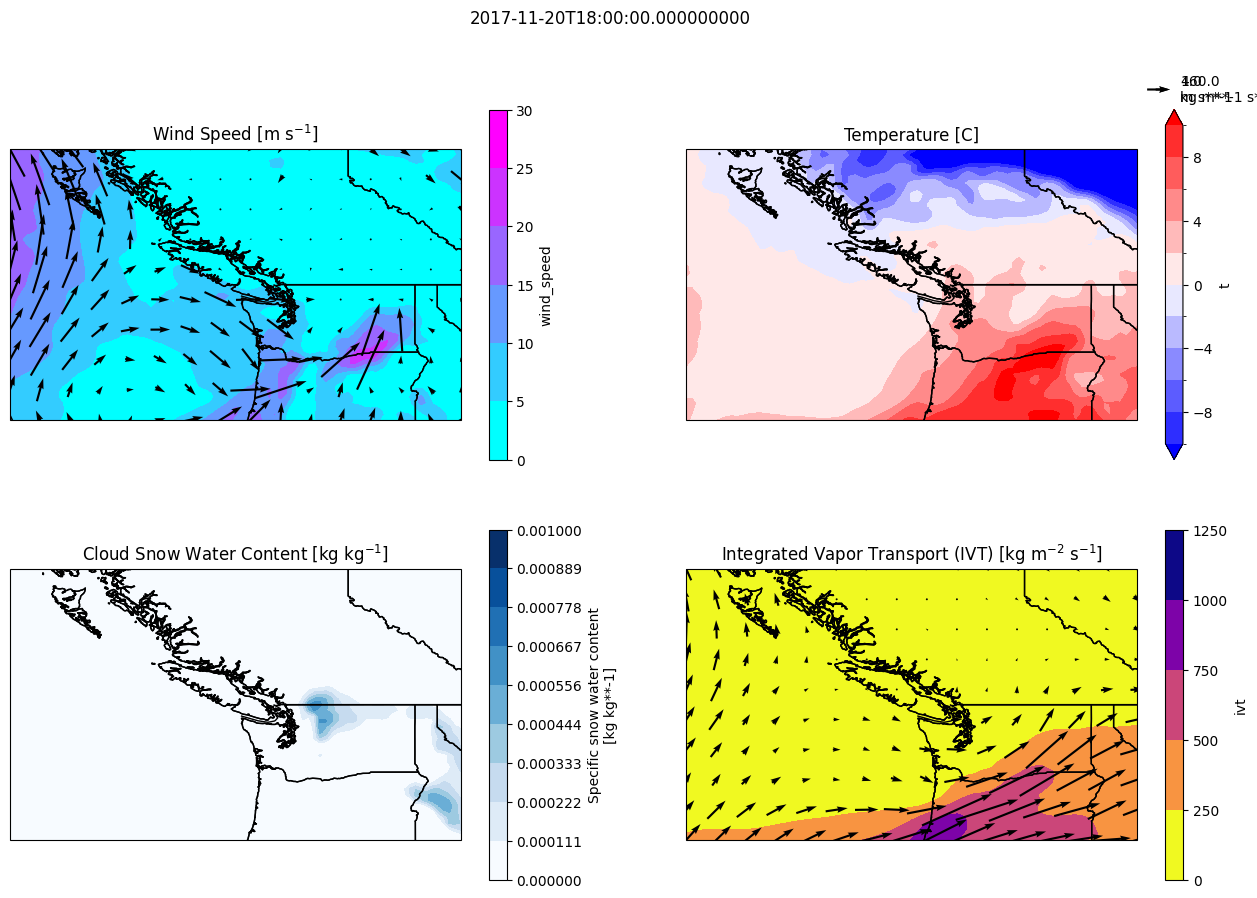

In [40]:
time_for_plot = event_df['event_start'].iloc[28] + pd.Timedelta(days=4)
# create 4 subplots with ccrs.PlateCarree() as the projection
fig, axs = plt.subplots(2,2, figsize=(16,10), subplot_kw={'projection': ccrs.PlateCarree()})
# set the extent of all plots
axs = axs.flatten()
for ax in axs:
    ax.set_extent([-135, -115, 43, 55], ccrs.PlateCarree())
    # add coastlines to all plots
    ax.coastlines()
    # add state boundaries to all plots
    ax.add_feature(cfeature.STATES)
    # add country boundaries to all plots
    ax.add_feature(cfeature.BORDERS)

# for the first subplot, plot the wind speed at 900 hPa
# plot the wind speed at the first time step for the first level using contourf
era5_ds_filter.sel(time=time_for_plot, level=900).wind_speed.plot.contourf(transform=ccrs.PlateCarree(), regrid_shape=10, levels=7, cmap='cool', ax=axs[0], vmin=0, vmax=30)
# plot the vectors of u an v wind components at the first time step for the first level using quiver
era5_ds_filter.sel(time=time_for_plot, level=900).plot.quiver('longitude', 'latitude', 'u', 'v', transform=ccrs.PlateCarree(), regrid_shape=10, ax=axs[0] )
# add title
axs[0].set_title('Wind Speed [m s$^{-1}$]')

# for the second subplot, plot the temperature at 900 hPa
# convert from kelvin to celsius and make the colorabar every 5 degrees
(era5_ds_filter.sel(time=time_for_plot, level=900).t - 273.15).plot.contourf(transform=ccrs.PlateCarree(), regrid_shape=10, levels=11, cmap='bwr', ax=axs[1], vmin=-10, vmax=10)
# add title
axs[1].set_title('Temperature [C]')

# plot the countours of the total cloud snow water content
era5_ds_filter.sel(time=time_for_plot, level=900).cswc.plot.contourf(transform=ccrs.PlateCarree(), regrid_shape=10, levels=10, cmap='Blues', ax=axs[2], vmin=0, vmax=0.001)
# add title
axs[2].set_title('Cloud Snow Water Content [kg kg$^{-1}$]')

# plot the contours of ivt 
era5_single_lvl_ds_filter.sel(time=time_for_plot).ivt.plot.contourf(transform=ccrs.PlateCarree(), regrid_shape=10, levels=6, cmap='plasma_r', ax=axs[3], vmin=0, vmax=1250)
era5_single_lvl_ds_filter.sel(time=time_for_plot).plot.quiver('longitude', 'latitude', 'p71.162', 'p72.162', transform=ccrs.PlateCarree(), regrid_shape=10, ax=axs[3] )
# make sure the units appear in the colorbar
axs[3].set_title('Integrated Vapor Transport (IVT) [kg m$^{-2}$ s$^{-1}$]')
# add a fig title for the time
fig.suptitle(era5_ds_filter.sel(time=time_for_plot).time.values)

In [23]:

# open the snotel dataset
wa_snotel_ds = xr.open_dataset('../data/01_raw/snotel/data_snotel_wa_4000ft.nc')

# locations 
sntl_locs = wa_snotel_ds.isel(time=0).to_dataframe().reset_index()
# using plotly, plot the location of the snotel stations
fig = px.scatter_geo(sntl_locs, lat="lat", lon="lon", hover_name="site", hover_data=["elevation"], color_discrete_sequence=["fuchsia"],
                     # add extent of map to be the PNW
                    scope='usa', center={'lat': 47.5, 'lon': -120},
                     # make 600 x 400
                     width=600, height=400)
# overlay north america
fig.update_geos(showcountries=True, countrycolor="Black",
                showsubunits=True, subunitcolor="Blue",
                fitbounds="locations")
# add the state boundaries
fig.show()

In [21]:
# create an empty dataframe with the same index as event_df and the columns as the snotel stations
snotel_ar_event_df = pd.DataFrame(index=event_df.index, columns=wa_snotel_ds.site)
# for each event in the event_df, get the difference in snow depth between the start and end of the event
for event in event_df.index:
    # get the snow depth at the start of the event
    snow_depth_start = wa_snotel_ds.sel(time=event_df.loc[event]['event_start'].date(), method='nearest').SNOWDEPTH
    # get the snow depth at the end of the event
    snow_depth_end = wa_snotel_ds.sel(time=event_df.loc[event]['event_end'].date(), method='nearest').SNOWDEPTH
    # get the difference in snow depth
    snow_depth_diff = snow_depth_end - snow_depth_start
    # add this to the event_df
    snotel_ar_event_df.loc[event] = snow_depth_diff
# add this to the plotly plot


AttributeError: 'Dataset' object has no attribute 'SNOWDEPTH'